# Required

In [1]:
import os
import zipfile
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shutil
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, MaxPooling2D, Dropout, Conv2D, Flatten, BatchNormalization, Add, Input, Activation
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
path = '/content/gdrive/MyDrive/ColabNotebooks/imagedb_btsd.zip'

In [4]:
local_zip = 'imagedb_btsd.zip'
zip_ref = zipfile.ZipFile(path, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [5]:
train_dir = 'imagedb'
validation_dir = 'imagedb_test'

# Φάκελος αποθήκευσης augmented εικόνων
augmented_dir = "augmented_data"
os.makedirs(augmented_dir, exist_ok=True)

val_dir = 'val_dir'
test_dir = 'test_dir'

# Δημιουργία νέων φακέλων
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Διαχωρισμός val-set (15%) και test-set (85%)
for category in os.listdir(validation_dir):
    category_path = os.path.join(validation_dir, category)
    if os.path.isdir(category_path):
        files = os.listdir(category_path)
        train_files, val_files = train_test_split(files, test_size=0.15, random_state=42)

        os.makedirs(os.path.join(val_dir, category), exist_ok=True)
        os.makedirs(os.path.join(test_dir, category), exist_ok=True)

        # Μετακίνηση αρχείων στο val_dir
        for file in val_files:
            shutil.move(os.path.join(category_path, file), os.path.join(val_dir, category, file))

        # Μετακίνηση αρχείων στο test_dir
        for file in train_files:
            shutil.move(os.path.join(category_path, file), os.path.join(test_dir, category, file))

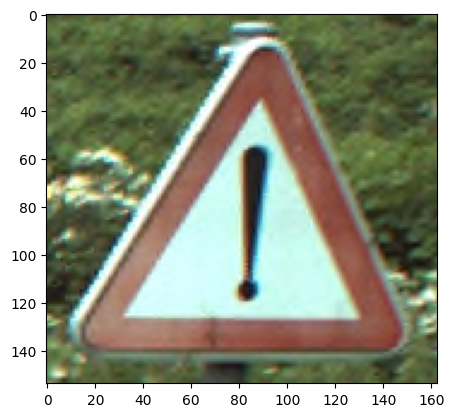

In [6]:
img_path = "/content/imagedb/00013/00138_00000.ppm"
img = mpimg.imread(img_path)
plt.imshow(img, cmap='gray')

plt.show()

# NOT pre-trained

In [ ]:
train_datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(28, 28),
    batch_size=80,
    class_mode='categorical',
    color_mode='rgb'
    #color_mode='grayscale'
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(28, 28),
    batch_size=80,
    class_mode='categorical',
    color_mode='rgb'
    #color_mode='grayscale'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(28, 28),
    batch_size=80,
    class_mode='categorical',
    color_mode='rgb'
    #color_mode='grayscale'
)

Found 3056 images belonging to 34 classes.
Found 339 images belonging to 34 classes.
Found 1810 images belonging to 34 classes.


In [ ]:
# Δημιουργία Data Augmentation με random crop και zoom

augmented_generator = ImageDataGenerator(
    rescale=1.0 / 255.0,    # Κανονικοποίηση
    zoom_range=0.2,         # Εφαρμογή zoom
    height_shift_range=0.2, # Μετατόπιση ύψους
    width_shift_range=0.2,  # Μετατόπιση πλάτους
    preprocessing_function=lambda img: tf.image.resize(
        tf.image.random_crop(img, size=(24, 24, 3)), (28, 28)
    )
)

augmented_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(28, 28),
    batch_size=80,
    class_mode='categorical',
    #save_to_dir=augmented_dir,
    save_prefix="aug",
    save_format="jpeg"
)

total_images = len(train_generator.filenames)  # Συνολικός αριθμός εικόνων στο train set
augmented_images_count = total_images // 4     # 1/4 των εικόνων

# Δημιουργία batch augmented δεδομένων
augmented_images = []
augmented_labels = []

for i in range(augmented_images_count // train_generator.batch_size):
    batch_data, batch_labels = next(train_generator)  # Παίρνουμε ένα batch δεδομένων
    augmented_images.append(batch_data)
    augmented_labels.append(batch_labels)

images_to_save_per_class = 2

# Λεξικό για την παρακολούθηση αποθηκευμένων εικόνων ανά κατηγορία
saved_images_per_class = {class_name: 0 for class_name in train_generator.class_indices.keys()}

# Αποθήκευση augmented εικόνων στη σωστή δομή φακέλων
for batch_data, batch_labels in train_generator:
    for j, img in enumerate(batch_data):
        # Υπολογισμός της σωστής κατηγορίας
        class_idx = tf.argmax(batch_labels[j]).numpy()
        class_name = list(train_generator.class_indices.keys())[class_idx]

        # Έλεγχος αν έχουν ήδη αποθηκευτεί 2 εικόνες για την κατηγορία
        if saved_images_per_class[class_name] >= images_to_save_per_class:
            continue

        # Δημιουργία φακέλου για την κατηγορία, αν δεν υπάρχει ήδη
        class_dir = os.path.join(augmented_dir, class_name)
        os.makedirs(class_dir, exist_ok=True)

        img_filename = f"aug_{class_name}_{saved_images_per_class[class_name]}.jpeg"
        img_path = os.path.join(class_dir, img_filename)
        tf.keras.utils.save_img(img_path, img)

        saved_images_per_class[class_name] += 1

        #print(f"Αποθηκεύτηκε εικόνα: {img_filename} στη κατηγορία: {class_name}")

    # Διακοπή όταν όλες οι κατηγορίες έχουν 2 εικόνες
    if all(count >= images_to_save_per_class for count in saved_images_per_class.values()):
        break

print(f"Αποθηκεύτηκαν συνολικά 2 εικόνες για κάθε κατηγορία στο {augmented_dir}.")

augmented_images = np.concatenate(augmented_images)
augmented_labels = np.concatenate(augmented_labels)

print(f"Augmented images: {augmented_images.shape}, Augmented labels: {augmented_labels.shape}")

Found 3056 images belonging to 34 classes.
Αποθηκεύτηκαν συνολικά 2 εικόνες για κάθε κατηγορία στο augmented_data.
Augmented images: (720, 28, 28, 3), Augmented labels: (720, 34)


In [ ]:
# Δημιουργία Data Augmentation με ασπρόμαυρες εικόνες

bw_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    zoom_range=0.2,
    preprocessing_function=lambda img: tf.image.rgb_to_grayscale(img)
)


bw_generator = bw_datagen.flow_from_directory(
    train_dir,
    target_size=(28, 28),
    batch_size=80,
    class_mode='categorical',
    save_prefix="bw_aug",
    save_format="jpeg"
)


images_to_save_per_class = 2

# Λεξικό για την παρακολούθηση αποθηκευμένων εικόνων ανά κατηγορία
saved_images_per_class = {class_name: 0 for class_name in train_generator.class_indices.keys()}

# Αποθήκευση augmented εικόνων στη σωστή δομή φακέλων
for batch_data, batch_labels in train_generator:
    for j, img in enumerate(batch_data):
        # Υπολογισμός της σωστής κατηγορίας
        class_idx = tf.argmax(batch_labels[j]).numpy()
        class_name = list(train_generator.class_indices.keys())[class_idx]

        # Έλεγχος αν έχουν ήδη αποθηκευτεί 2 εικόνες για την κατηγορία
        if saved_images_per_class[class_name] >= images_to_save_per_class:
            continue

        # Δημιουργία φακέλου για την κατηγορία, αν δεν υπάρχει ήδη
        class_dir = os.path.join(augmented_dir, class_name)pretrained
        os.makedirs(class_dir, exist_ok=True)

        img_filename = f"bw_aug_{class_name}_{saved_images_per_class[class_name]}.jpeg"
        img_path = os.path.join(class_dir, img_filename)
        tf.keras.utils.save_img(img_path, img)

        saved_images_per_class[class_name] += 1

        #print(f"Αποθηκεύτηκε εικόνα: {img_filename} στη κατηγορία: {class_name}")

    # Διακοπή όταν όλες οι κατηγορίες έχουν 2 εικόνες
    if all(count >= images_to_save_per_class for count in saved_images_per_class.values()):
        break

print(f"Αποθηκεύτηκαν συνολικά 2 εικόνες για κάθε κατηγορία στο {augmented_dir}.")

Found 3056 images belonging to 34 classes.
Αποθηκεύτηκαν συνολικά 2 εικόνες για κάθε κατηγορία στο augmented_data.


In [ ]:
# Αντιγραφή εικόνων από το augmented_dir στο train_dir

categories = os.listdir(train_dir)

for category in categories:
    train_category_path = os.path.join(train_dir, category)
    augmented_category_path = os.path.join(augmented_dir, category)

    # Ελέγχουμε αν η κατηγορία υπάρχει και στο augmented_dir
    if not os.path.exists(augmented_category_path):
        print(f"Ο φάκελος {augmented_category_path} δεν υπάρχει. Παραλείπεται.")
        continue

    # Αντιγραφή εικόνων από το augmented_dir στο αντίστοιχο train_dir
    for img_file in os.listdir(augmented_category_path):
        src = os.path.join(augmented_category_path, img_file)
        dst = os.path.join(train_category_path, img_file)
        shutil.copy(src, dst)

print(f"Οι εικόνες από το {augmented_dir} αντιγράφηκαν επιτυχώς στο {train_dir}.")pretrained

Οι εικόνες από το augmented_data αντιγράφηκαν επιτυχώς στο imagedb.


In [ ]:
# Συνάρτηση για δημιουργία ενός Block
def add_block(model, filters, kernel_size=(3, 3), pool_size=(2, 2), dropout_rate=0.25):
    model.add(tf.keras.layers.Conv2D(filters, kernel_size, strides=(1, 1), activation='relu', padding='same'))
    model.add(tf.keras.layers.Conv2D(filters, kernel_size, strides=(1, 1), activation='relu', padding='same'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=pool_size, strides=(2, 2)))
    model.add(tf.keras.layers.Dropout(dropout_rate))

# Δημιουργία μοντέλου Sequential
model = tf.keras.models.Sequential()

# Input Layer
model.add(tf.keras.layers.Conv2D(32, (3, 3), strides=(1, 1), activation='relu', input_shape=(28, 28, 3)))

# Προσθήκη blocks δυναμικά
filters_list = [32, 64, 128, 256]  # Αύξηση φίλτρων ανά block
dropout_rates = [0.5, 0.25, 0.125, 0.0625]

for filters, dropout_rate in zip(filters_list, dropout_rates):
    add_block(model, filters, dropout_rate=dropout_rate)

# Classifier
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(2048, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1024, activation='relu'))
model.add(tf.keras.layers.Dense(34, activation='softmax'))  # Αριθμός κατηγοριών

# Σύνταξη του μοντέλου
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Επισκόπηση του μοντέλου
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 26, 26, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 26, 26, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 26, 26, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 13, 13, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 6, 6, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 6, 6, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 3, 3, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 3, 3, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 1, 1, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 1, 1, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2048)                │         526,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,840,866 (14.65 MB)

 Trainable params: 3,840,866 (14.65 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
callbacks = []

# Αποθήκευση των καλύτερων βαρών με σωστή κατάληξη
save_best_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_weights.keras',
    save_best_only=True,
    verbose=1
)
callbacks.append(save_best_callback)

# Πρόωρη διακοπή
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    patience=20, restore_best_weights=True, verbose=1
)
callbacks.append(early_stop_callback)

# Εκπαίδευση του μοντέλου
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=50, #train_generator.samples // train_generator.batch_size,
    epochs=100,
    validation_steps=35, #validation_generator.samples // validation_generator.batch_size,
    verbose=1,
    callbacks=callbacks
)


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


39/50 ━━━━━━━━━━━━━━━━━━━━ 2s 210ms/step - accuracy: 0.0863 - loss: 3.6777

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 1: val_loss improved from inf to 3.26483, saving model to best_weights.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 228ms/step - accuracy: 0.0883 - loss: 3.6117 - val_accuracy: 0.0944 - val_loss: 3.2648
Epoch 2/100
36/50 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.1085 - loss: 3.1470
Epoch 2: val_loss improved from 3.26483 to 2.50655, saving model to best_weights.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.1171 - loss: 3.1065 - val_accuracy: 0.1976 - val_loss: 2.5065
Epoch 3/100
38/50 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2618 - loss: 2.4061
Epoch 3: val_loss improved from 2.50655 to 1.85439, saving model to best_weights.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.2758 - loss: 2.3632 - val_accuracy: 0.4071 - val_loss: 1.8544
Epoch 4/100
39/50 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4653 - loss: 1.7456
Epoch 4: val_loss improved from 1.85439 to 1.25082, saving model to best_weights.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accur

In [ ]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(28, 28),
    batch_size=80,
    class_mode='categorical',
    color_mode='rgb'
)

# Αξιολόγηση του μοντέλου
loss, acc = model.evaluate(test_generator)
print(f"Test Accuracy: {acc}")

Found 1810 images belonging to 34 classes.
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.9766 - loss: 0.2438
Test Accuracy: 0.9801105260848999


# ResNet50

In [7]:
train_datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
    train_dir,
    #rescale=1.0 / 255.0,
    target_size=(224, 224),
    batch_size=80,
    class_mode='categorical',
    color_mode='rgb'
    #color_mode='grayscale'
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    #rescale=1.0 / 255.0,
    target_size=(224, 224),
    batch_size=80,
    class_mode='categorical',
    color_mode='rgb'
    #color_mode='grayscale'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    #rescale=1.0 / 255.0,
    target_size=(224, 224),
    batch_size=80,
    class_mode='categorical',
    color_mode='rgb'
    #color_mode='grayscale'
)

Found 3056 images belonging to 34 classes.
Found 339 images belonging to 34 classes.
Found 1810 images belonging to 34 classes.


In [8]:
# Δημιουργία Data Augmentation με random crop και zoom

augmented_generator = ImageDataGenerator(
    rescale=1.0 / 255.0,    # Κανονικοποίηση
    zoom_range=0.2,         # Εφαρμογή zoom
    height_shift_range=0.2, # Μετατόπιση ύψους
    width_shift_range=0.2,  # Μετατόπιση πλάτους
    preprocessing_function=lambda img: tf.image.resize(
        tf.image.random_crop(img, size=(224, 224, 3)), (224, 224)
    )
)

augmented_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=80,
    class_mode='categorical',
    save_prefix="aug",
    save_format="jpeg"
)

total_images = len(train_generator.filenames)  # Συνολικός αριθμός εικόνων στο train set
augmented_images_count = total_images // 4     # 1/4 των εικόνων

# Δημιουργία batch augmented δεδομένων
augmented_images = []
augmented_labels = []

for i in range(augmented_images_count // train_generator.batch_size):
    batch_data, batch_labels = next(train_generator)  # Παίρνουμε ένα batch δεδομένων
    augmented_images.append(batch_data)
    augmented_labels.append(batch_labels)

images_to_save_per_class = 2

# Λεξικό για την παρακολούθηση αποθηκευμένων εικόνων ανά κατηγορία
saved_images_per_class = {class_name: 0 for class_name in train_generator.class_indices.keys()}

# Αποθήκευση augmented εικόνων στη σωστή δομή φακέλων
for batch_data, batch_labels in train_generator:
    for j, img in enumerate(batch_data):
        # Υπολογισμός της σωστής κατηγορίας
        class_idx = tf.argmax(batch_labels[j]).numpy()
        class_name = list(train_generator.class_indices.keys())[class_idx]

        # Έλεγχος αν έχουν ήδη αποθηκευτεί 2 εικόνες για την κατηγορία
        if saved_images_per_class[class_name] >= images_to_save_per_class:
            continue

        # Δημιουργία φακέλου για την κατηγορία, αν δεν υπάρχει ήδη
        class_dir = os.path.join(augmented_dir, class_name)
        os.makedirs(class_dir, exist_ok=True)

        img_filename = f"aug_{class_name}_{saved_images_per_class[class_name]}.jpeg"
        img_path = os.path.join(class_dir, img_filename)
        tf.keras.utils.save_img(img_path, img)

        saved_images_per_class[class_name] += 1

        #print(f"Αποθηκεύτηκε εικόνα: {img_filename} στη κατηγορία: {class_name}")

    # Διακοπή όταν όλες οι κατηγορίες έχουν 2 εικόνες
    if all(count >= images_to_save_per_class for count in saved_images_per_class.values()):
        break

print(f"Αποθηκεύτηκαν συνολικά 2 εικόνες για κάθε κατηγορία στο {augmented_dir}.")


augmented_images = np.concatenate(augmented_images)
augmented_labels = np.concatenate(augmented_labels)


print(f"Augmented images: {augmented_images.shape}, Augmented labels: {augmented_labels.shape}")

Found 3056 images belonging to 34 classes.
Αποθηκεύτηκαν συνολικά 2 εικόνες για κάθε κατηγορία στο augmented_data.
Augmented images: (720, 224, 224, 3), Augmented labels: (720, 34)


In [9]:
# Δημιουργία Data Augmentation με ασπρόμαυρες εικόνες

bw_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    zoom_range=0.2,
    preprocessing_function=lambda img: tf.image.rgb_to_grayscale(img)
)


bw_generator = bw_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=80,
    class_mode='categorical',
    save_prefix="bw_aug",
    save_format="jpeg"
)

images_to_save_per_class = 2

# Λεξικό για την παρακολούθηση αποθηκευμένων εικόνων ανά κατηγορία
saved_images_per_class = {class_name: 0 for class_name in train_generator.class_indices.keys()}

# Αποθήκευση augmented εικόνων στη σωστή δομή φακέλων
for batch_data, batch_labels in train_generator:
    for j, img in enumerate(batch_data):
        # Υπολογισμός της σωστής κατηγορίας
        class_idx = tf.argmax(batch_labels[j]).numpy()
        class_name = list(train_generator.class_indices.keys())[class_idx]

        # Έλεγχος αν έχουν ήδη αποθηκευτεί 2 εικόνες για την κατηγορία
        if saved_images_per_class[class_name] >= images_to_save_per_class:
            continue

        # Δημιουργία φακέλου για την κατηγορία, αν δεν υπάρχει ήδη
        class_dir = os.path.join(augmented_dir, class_name)
        os.makedirs(class_dir, exist_ok=True)

        img_filename = f"bw_aug_{class_name}_{saved_images_per_class[class_name]}.jpeg"
        img_path = os.path.join(class_dir, img_filename)
        tf.keras.utils.save_img(img_path, img)

        saved_images_per_class[class_name] += 1

        #print(f"Αποθηκεύτηκε εικόνα: {img_filename} στη κατηγορία: {class_name}")

    # Διακοπή όταν όλες οι κατηγορίες έχουν 2 εικόνες
    if all(count >= images_to_save_per_class for count in saved_images_per_class.values()):
        break

print(f"Αποθηκεύτηκαν συνολικά 2 εικόνες για κάθε κατηγορία στο {augmented_dir}.")


augmented_images = np.concatenate(augmented_images)
augmented_labels = np.concatenate(augmented_labels)


print(f"Augmented images: {augmented_images.shape}, Augmented labels: {augmented_labels.shape}")

Found 3056 images belonging to 34 classes.
Αποθηκεύτηκαν συνολικά 2 εικόνες για κάθε κατηγορία στο augmented_data.
Augmented images: (161280, 224, 3), Augmented labels: (24480,)


In [8]:
# Fine - tuning

# Φόρτωση του ResNet50 με προ-εκπαιδευμένα βάρη από το ImageNet : 175 layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Layers που περιέχουν βάρη (trainable parameters) : 106 layers
layers_with_weights = [layer for layer in base_model.layers if layer.weights]
print(f"Αριθμός layers με βάρη: {len(layers_with_weights)}")

# Πάγωμα όλων των επιπέδων
for layer in layers_with_weights:
    layer.trainable = False

# Ξεπάγωμα τελευταίου Residual Block (Conv5_X)
for layer in layers_with_weights[80:]:
    layer.trainable = True

print(f"Συνολικός αριθμός επιπέδων στη βάση του ResNet50: {len(base_model.layers)}")

frozen_layers = sum([1 for layer in layers_with_weights if not layer.trainable])
trainable_layers = sum([1 for layer in layers_with_weights if layer.trainable])

print(f"Παγωμένα επίπεδα: {frozen_layers}")
print(f"Μη παγωμένα επίπεδα: {trainable_layers}")

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Αριθμός layers με βάρη: 106
Συνολικός αριθμός επιπέδων στη βάση του ResNet50: 175
Παγωμένα επίπεδα: 80
Μη παγωμένα επίπεδα: 26


In [11]:
# New Classifier (ONLY FOR DATA AUGMENTATION!!)
# Custom Residual Block
def add_residual_block(input_layer, filters):
    x = Conv2D(filters, (1, 1), strides=(1, 1), padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, (3, 3), strides=(1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters * 4, (1, 1), strides=(1, 1), padding='same')(x)
    x = BatchNormalization()(x)

    # Skip Connection
    shortcut = Conv2D(filters * 4, (1, 1), strides=(1, 1), padding='same')(input_layer)
    shortcut = BatchNormalization()(shortcut)

    # Add shortcut to the output
    x = Add()([x, shortcut])
    x = Activation('relu')(x)

    return x

# Προσαρμογή της αρχιτεκτονικής
model = Sequential()

# Προσθήκη του βασικού ResNet50
model.add(base_model)

input_layer = base_model.output

# Προσθέτουμε 3 επιπλέον residual blocks
x = add_residual_block(input_layer, 256)
#x = add_residual_block(x, 512)
#x = add_residual_block(x, 1024)

# Τελικά επίπεδα
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.6)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output_layer = Dense(34, activation='softmax')(x)  # 34 κατηγορίες

# Σύνθεση του μοντέλου
model = Model(inputs=base_model.input, outputs=output_layer)

# Σύνταξη του μοντέλου
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Επισκόπηση του μοντέλου
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 27,668,770 (105.55 MB)

 Trainable params: 20,170,658 (76.94 MB)

 Non-trainable params: 7,498,112 (28.60 MB)

In [9]:
# Χρήση προ-εκπαιδευμένου δικτύου: ResNet50

# Προσαρμογή του δικτύου για το dataset
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.6),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(34, activation='softmax')  # 34 κατηγορίες
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 34)                  │           4,386 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,706,850 (94.25 MB)

 Trainable params: 17,213,858 (65.67 MB)

 Non-trainable params: 7,492,992 (28.58 MB)

In [10]:
callbacks = []

# Αποθήκευση των καλύτερων βαρών με σωστή κατάληξη
save_best_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/gdrive/MyDrive/ColabNotebooks/resnet50_best_model.h5',  # Αποθήκευση ως HDF5
    save_best_only=True,
    save_weights_only=False,  # ✅ Αποθηκεύει όλο το μοντέλο, όχι μόνο τα weights!
    verbose=1
)
callbacks.append(save_best_callback)

# Πρόωρη διακοπή
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    patience=10, restore_best_weights=True, verbose=1
)
callbacks.append(early_stop_callback)

# Εκπαίδευση του μοντέλου
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch= 50, #train_generator.samples // train_generator.batch_size,
    epochs=60,
    validation_steps= 35, #validation_generator.samples // validation_generator.batch_size,
    verbose=1,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/60
39/50 ━━━━━━━━━━━━━━━━━━━━ 6s 580ms/step - accuracy: 0.4745 - loss: 2.0930

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_loss improved from inf to 17.24248, saving model to /content/gdrive/MyDrive/ColabNotebooks/resnet50_best_model.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 69s 652ms/step - accuracy: 0.5172 - loss: 1.9203 - val_accuracy: 0.4454 - val_loss: 17.2425
Epoch 2/60
39/50 ━━━━━━━━━━━━━━━━━━━━ 3s 285ms/step - accuracy: 0.8989 - loss: 0.3732
Epoch 2: val_loss improved from 17.24248 to 1.94046, saving model to /content/gdrive/MyDrive/ColabNotebooks/resnet50_best_model.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 46s 318ms/step - accuracy: 0.9019 - loss: 0.3616 - val_accuracy: 0.8407 - val_loss: 1.9405
Epoch 3/60
39/50 ━━━━━━━━━━━━━━━━━━━━ 3s 292ms/step - accuracy: 0.9344 - loss: 0.2184
Epoch 3: val_loss did not improve from 1.94046
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 247ms/step - accuracy: 0.9327 - loss: 0.2336 - val_accuracy: 0.2448 - val_loss: 68.5149
Epoch 4/60
39/50 ━━━━━━━━━━━━━━━━━━━━ 3s 292ms/step - accuracy: 0.9255 - loss: 0.3349
Epoch 4: val_loss did not improve from 1.94046
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 246ms/step - accuracy: 0.9266 - loss: 0.3265 - val_accuracy: 0.3333 - val_loss: 26.7380
Epoch 5/60
39/50 ━━━━━━━━━━━━━━━━━━━━ 3s 296ms/step - accuracy: 0.9662 - loss: 0.1344
Epoch 5: val_loss did not improve from 1.94046
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 250ms/step - accuracy: 0.9662 - loss: 0.1356 - val_accuracy: 0.6637 - val_loss: 25.5536
Epoch 6/60
39/50 ━━━━━━━━━━━━━━━━━━━━ 3s 301ms/step - accuracy: 0.9728 - loss: 0.1209
Epoch 6: val_loss did not improve from 1

50/50 ━━━━━━━━━━━━━━━━━━━━ 16s 325ms/step - accuracy: 0.9915 - loss: 0.0646 - val_accuracy: 0.9351 - val_loss: 0.6171
Epoch 12/60
39/50 ━━━━━━━━━━━━━━━━━━━━ 3s 305ms/step - accuracy: 0.9833 - loss: 0.0759
Epoch 12: val_loss improved from 0.61712 to 0.37306, saving model to /content/gdrive/MyDrive/ColabNotebooks/resnet50_best_model.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 326ms/step - accuracy: 0.9833 - loss: 0.0762 - val_accuracy: 0.9558 - val_loss: 0.3731
Epoch 13/60
39/50 ━━━━━━━━━━━━━━━━━━━━ 3s 304ms/step - accuracy: 0.9851 - loss: 0.0449
Epoch 13: val_loss improved from 0.37306 to 0.28276, saving model to /content/gdrive/MyDrive/ColabNotebooks/resnet50_best_model.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 344ms/step - accuracy: 0.9858 - loss: 0.0428 - val_accuracy: 0.9705 - val_loss: 0.2828
Epoch 14/60
39/50 ━━━━━━━━━━━━━━━━━━━━ 3s 304ms/step - accuracy: 0.9958 - loss: 0.0195
Epoch 14: val_loss improved from 0.28276 to 0.22329, saving model to /content/gdrive/MyDrive/ColabNotebooks/resnet50_best_model.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 302ms/step - accuracy: 0.9962 - loss: 0.0183 - val_accuracy: 0.9735 - val_loss: 0.2233
Epoch 15/60
39/50 ━━━━━━━━━━━━━━━━━━━━ 3s 301ms/step - accuracy: 0.9985 - loss: 0.0052
Epoch 15: val_loss improved from 0.22329 to 0.18228, saving model to /content/gdrive/MyDrive/ColabNotebooks/resnet50_best_model.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 296ms/step - accuracy: 0.9984 - loss: 0.0055 - val_accuracy: 0.9705 - val_loss: 0.1823
Epoch 16/60
39/50 ━━━━━━━━━━━━━━━━━━━━ 3s 300ms/step - accuracy: 0.9989 - loss: 0.0045
Epoch 16: val_loss did not improve from 0.18228
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 257ms/step - accuracy: 0.9988 - loss: 0.0046 - val_accuracy: 0.9705 - val_loss: 0.2047
Epoch 17/60
39/50 ━━━━━━━━━━━━━━━━━━━━ 3s 298ms/step - accuracy: 0.9974 - loss: 0.0053
Epoch 17: val_loss improved from 0.18228 to 0.17927, saving model to /content/gdrive/MyDrive/ColabNotebooks/resnet50_best_model.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 28s 418ms/step - accuracy: 0.9976 - loss: 0.0051 - val_accuracy: 0.9764 - val_loss: 0.1793
Epoch 18/60
39/50 ━━━━━━━━━━━━━━━━━━━━ 3s 298ms/step - accuracy: 0.9996 - loss: 0.0020
Epoch 18: val_loss did not improve from 0.17927
50/50 ━━━━━━━━━━━━━━━━━━━━ 33s 251ms/step - accuracy: 0.9995 - loss: 0.0022 - val_accuracy: 0.9794 - val_loss: 0.1848
Epoch 19/60
39/50 ━━━━━━━━━━━━━━━━━━━━ 3s 305ms/step - accuracy: 0.9971 - loss: 0.0075
Epoch 19: val_loss did not improve from 0.17927
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 257ms/step - accuracy: 0.9968 - loss: 0.0097 - val_accuracy: 0.9705 - val_loss: 0.2817
Epoch 20/60
39/50 ━━━━━━━━━━━━━━━━━━━━ 3s 301ms/step - accuracy: 0.9976 - loss: 0.0089
Epoch 20: val_loss did not improve from 0.17927
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 254ms/step - accuracy: 0.9976 - loss: 0.0090 - val_accuracy: 0.9617 - val_loss: 0.3038
Epoch 21/60
39/50 ━━━━━━━━━━━━━━━━━━━━ 3s 303ms/step - accuracy: 0.9987 - loss: 0.0052
Epoch 21: val_loss did not improve f

In [11]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=80,
    class_mode='categorical',
    color_mode='rgb'
)

# Αξιολόγηση του μοντέλου
loss, acc = model.evaluate(test_generator)
print(f"Test Accuracy: {acc}")

Found 1810 images belonging to 34 classes.
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 477ms/step - accuracy: 0.9884 - loss: 0.0817
Test Accuracy: 0.9872928261756897


# Plots

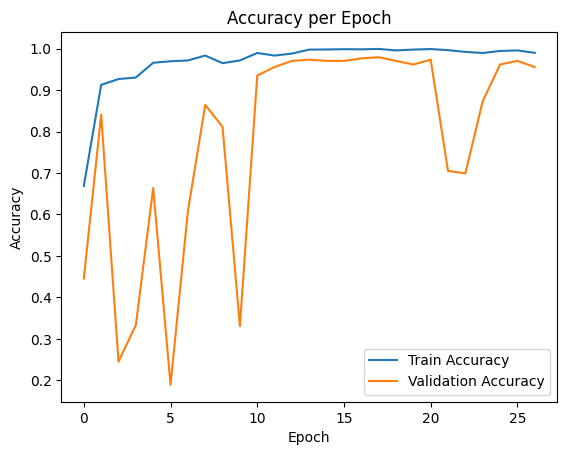

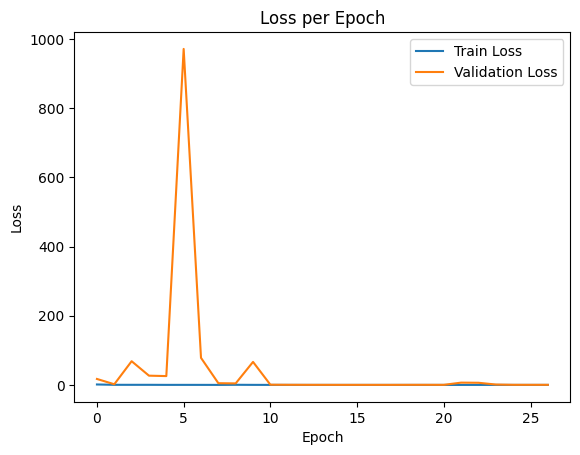

In [12]:
# Γράφημα ακρίβειας
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# Γράφημα απώλειας
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# PyTorch checkpoint

In [16]:
!pip install -q tf2onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.8/455.8 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 98.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 14.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.62.3 requires protobuf>=4.21.6, but you have protobuf 3.20.3 which is incompatible.
tensorflow-metadata 1.16.1 requires protobuf<6.0.0dev,>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.3 which is incompatible.


In [18]:
import tensorflow as tf
import tf2onnx

# Φόρτωση του Keras ResNet50 Sequential Model
model = tf.keras.models.load_model("/content/gdrive/MyDrive/ColabNotebooks/resnet50_best_model.h5")

# Μετατροπή του Sequential σε Functional API για να έχει output_names
inputs = tf.keras.Input(shape=(224, 224, 3), name="input_image")
outputs = model(inputs)  # Χρησιμοποιούμε το Sequential ως layer

functional_model = tf.keras.Model(inputs=inputs, outputs=outputs, name="resnet50_classifier")

# Αποθήκευση του Functional API Model
functional_model.save("/content/gdrive/MyDrive/ColabNotebooks/classification_model_functional.keras")

print("✔ Converted Sequential to Functional Model")


✔ Converted Sequential to Functional Model


In [20]:
import tensorflow as tf
import tf2onnx

# Φόρτωση του Functional API μοντέλου
model = tf.keras.models.load_model("/content/gdrive/MyDrive/ColabNotebooks/classification_model_functional.keras")

# Ορισμός Input Signature (Σημαντικό για την μετατροπή σε ONNX)
input_signature = [tf.TensorSpec([None, 224, 224, 3], tf.float32, name="input_image")]

# Μετατροπή του Keras Functional Model σε ONNX με καθορισμένο input signature
onnx_model_path = "/content/gdrive/MyDrive/ColabNotebooks/resnet50.onnx"
model_proto, _ = tf2onnx.convert.from_keras(model, output_path=onnx_model_path, input_signature=input_signature)

print(f"✔ Model successfully converted to ONNX: {onnx_model_path}")


✔ Model successfully converted to ONNX: /content/gdrive/MyDrive/ColabNotebooks/resnet50.onnx
